In [10]:
import random
import numpy as np
from numpy.random import uniform
from numpy import multiply
from scipy.ndimage.filters import gaussian_filter

import matplotlib.pyplot as plt
%matplotlib inline

from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.space import Grid
from mesa.datacollection import DataCollector
from mesa.batchrunner import BatchRunner

#### About

It's a simple adaptation of Mesa's [Forest Fire model]("https://github.com/projectmesa/mesa/tree/master/examples/forest_fire").

Briefly about the model

In addition with tulp and density of the grid, I apply height to each cell. In theory, tree located higher from the start are more likely to catch the fire and vice versa. For simplicity, I keep crisp outcomes and not probabilities.



1. Agent:

    1.1 tulp (x by y)
    
    1.2 height of the cell
    
    1.3 density
    
2. Model:
    
    2.1 If the tree is located in the same cell, it catches fire
    
    2.2 If the tree is located in the neighborhing higher cell, it catches fire
    
    2.3 If the tree is located in the lower cell, it won't catch fire

2. Batch running:
     
    fake_surface() ?

In [25]:
class TreeCell(Agent):
    def __init__(self, pos, model):
        """
        Create a new tree.
        Args:
            pos: The tree's coordinates on the grid.
            model: standard model reference for agent.
        """
        super().__init__(pos, model)  
        self.pos = pos
        self.condition = "Fine"
        

    def step(self):
        """
        If the tree is on fire, spread it to fine trees nearby.
        """
        if self.condition == "On Fire":
            for neighbor in self.model.grid.neighbor_iter(self.pos):
                if neighbor.condition == "Fine":
                    neighbor.condition = "On Fire"
            self.condition = "Burned Out"

    def get_pos(self):
        return self.pos

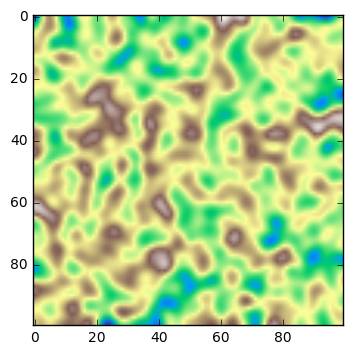

In [66]:
def fake_surface(dim=(100,100), low=500, high=1500, sigma=2):
    r = uniform(low, high, size=multiply(*dim)).reshape(dim)
    return gaussian_filter(r, sigma=sigma, truncate=9)
plt.imshow(fake_surface((100,100)), cmap=plt.get_cmap("terrain"))
plt.show()
surf=fake_surface()

In [88]:
class TreeCell(Agent):
    """
    A tree cell.
    Attributes:
        x, y: Grid coordinates
        condition: Can be "Fine", "On Fire", or "Burned Out"
        unique_id: (x,y) tuple.
    unique_id isn't strictly necessary here, but it's good
    practice to give one to each agent anyway.
    """
    def __init__(self, pos, model):
        """
        Create a new tree.
        Args:
            pos: The tree's coordinates on the grid.
            model: standard model reference for agent.
        """
        Agent.__init__(self, pos, model)
        self.pos = pos
        self.condition = "Fine"
        self.hght = surf[pos]

    def step(self):
        """
        If the tree is on fire, spread it to fine trees nearby.
        """
        if self.condition == "On Fire":
            for neighbor in self.model.grid.neighbor_iter(self.pos):
                if neighbor.condition == "Fine" and neighbor.hght>=self.hght:
                    neighbor.condition = "On Fire"
            self.condition = "Burned Out"
        
    def get_pos(self):
        return self.pos

In [89]:
class ForestFire(Model):
    """
    Simple Forest Fire model.
    """
    def __init__(self, height, width, density):
        """
        Create a new forest fire model.
        Args:
            height, width: The size of the grid to model
            density: What fraction of grid cells have a tree in them.
        """
        # Initialize model parameters
        self.height = height
        self.width = width
        self.density = density
        
        
        # Set up model objects
        self.schedule = RandomActivation(self)
        self.grid = Grid(height, width, torus=False)
        
        
        self.datacollector = DataCollector(
            {"Fine": lambda m: self.count_type(m, "Fine"),
             "On Fire": lambda m: self.count_type(m, "On Fire"),
             "Burned Out": lambda m: self.count_type(m, "Burned Out")})

        # Place a tree in each cell with Prob = density
        for (contents, x, y) in self.grid.coord_iter():
            if random.random() < self.density:
                # Create a tree
                new_tree = TreeCell((x, y), self)
                # Set all trees in the first column on fire.
                if x == 0:
                    new_tree.condition = "On Fire"
                self.grid._place_agent((x, y), new_tree)
                self.schedule.add(new_tree)
        self.running = True

    def step(self):
        """
        Advance the model by one step.
        """
        self.schedule.step()
        self.datacollector.collect(self)

        # Halt if no more fire
        if self.count_type(self, "On Fire") == 0:
            self.running = False

    @staticmethod
    def count_type(model, tree_condition):
        """
        Helper method to count trees in a given condition in a given model.
        """
        count = 0
        for tree in model.schedule.agents:
            if tree.condition == tree_condition:
                count += 1
        return count

In [90]:
fire=ForestFire(100, 100, 0.6)
fire.run_model()

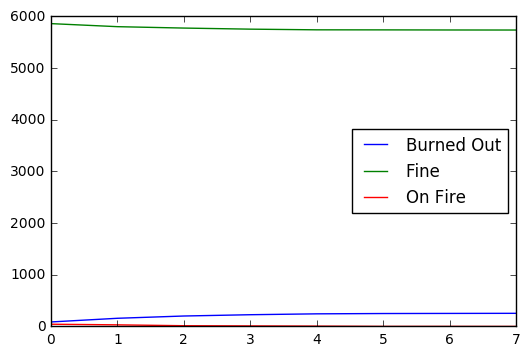

In [91]:
results = fire.datacollector.get_model_vars_dataframe()
results.plot()


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 48.10it/s]


(0, 1)

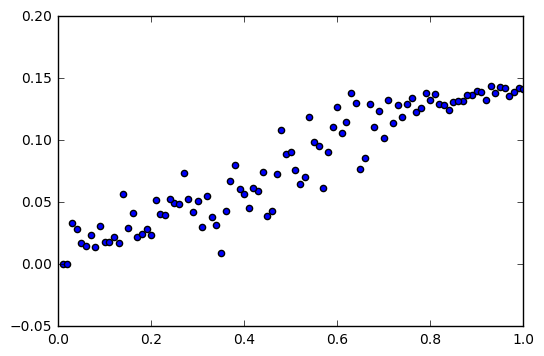

In [92]:
param_set = dict(height=50, # Height and width are constant
                 width=50,
                 # Vary density from 0.01 to 1, in 0.01 increments:
                 density=np.linspace(0,1,101)[1:])
# At the end of each model run, calculate the fraction of trees which are Burned Out
model_reporter = {"BurnedOut": lambda m: (ForestFire.count_type(m, "Burned Out") / 
                                          m.schedule.get_agent_count()) }
param_run = BatchRunner(ForestFire, param_set, model_reporters=model_reporter)

param_run.run_all()
df = param_run.get_model_vars_dataframe()
plt.scatter(df.density, df.BurnedOut)
plt.xlim(0,1)
